# Puffins classifier

The goal of this task is to develop a model capable of accurately classifying puffers species (response variable) based on their body mass, wing length, beak length and beak depth (features).


In [179]:
#Import all the libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support


## Data cleaning 

The data was opened from a GitHub repository and then cleaned. First, empty values were discarded. Next, the names of the response variable (Arctica, Cirrhata, and Corniculata) were checked for consistency throughout the dataset. Finally, the features were evaluated using descriptive statistics to identify any incoherent values

In [71]:
# Open data 
data = pd.read_csv("https://raw.githubusercontent.com/nicoleamorveli/puffins_classifier/main/puffins.csv")
data.head()


,body_mass_kg,wing_length_m,beak_length_mm,beak_depth_mm,species
0,1.384,0.181,39.243,18.304,Arctica
1,1.717,0.189,44.084,19.240,Arctica
2,1.717,0.184,40.376,19.344,Arctica
3,1.414,0.187,37.904,19.240,Arctica
4,1.273,0.177,37.595,18.720,Arctica


In [84]:
#Clean the data 
data.dropna(inplace=True)

#Check for consistency in species names
species_counts = data['species'].value_counts()
print(species_counts)

#Check for consistency in values
print(data.describe())

Arctica        150
Corniculata    122
Cirrhata        68
Name: species, dtype: int64
       body_mass_kg  wing_length_m  beak_length_mm  beak_depth_mm
count    340.000000     340.000000      340.000000     340.000000
mean       1.696718       0.194806       45.241841      17.835694
std        0.321619       0.013667        5.608138       2.057863
min        1.091000       0.167000       33.063000      13.624000
25%        1.434000       0.184000       40.453250      16.198000
50%        1.636000       0.191000       45.783500      17.992000
75%        1.919000       0.207000       49.955000      19.448000
max        2.545000       0.224000       61.388000      22.360000


## Data visualization 

Because the response variable is categorical, the data was visualized using boxplots to compare the species against each of the features. The goal was to observe if there were notable differences in behavior between the species. Subsequently, a new dataframe was created with the mean of each feature to plot it against each species. This was also done to facilitate the visualization of any differences

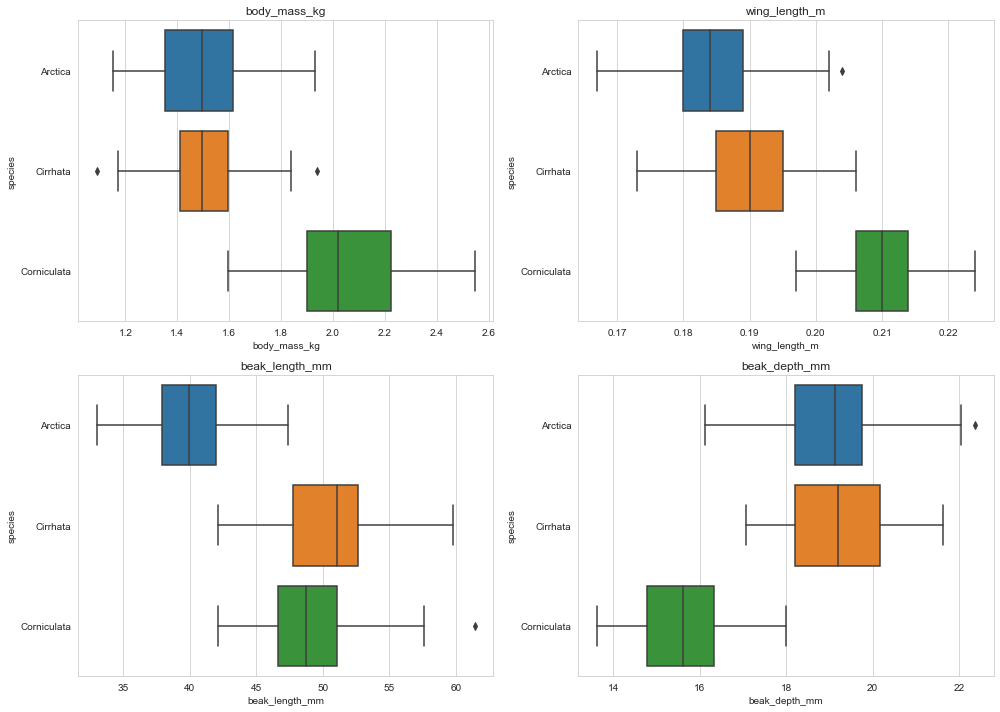

In [76]:
#Plot data using boxplots 

sns.set_style("whitegrid")

variables = data.columns[:-1]  # Exclude the last column ('species')

#Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

#Flatten axes array
axes = axes.flatten()

#Loop through each variable and create boxplot
for i, var in enumerate(variables):
    sns.boxplot(data=data, x=var, y='species', ax=axes[i])
    axes[i].set_title(var)

plt.tight_layout()
#Show plot
plt.show()

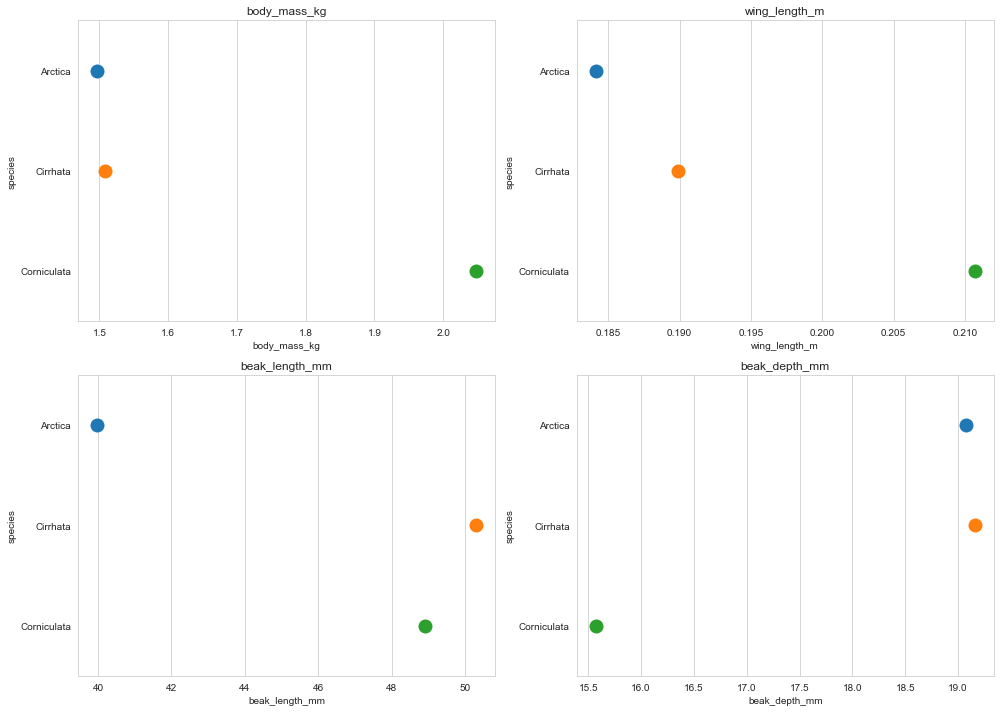

In [172]:
#Visualization using means

#Get means of each and visualize if there is a clear difference
mean_data = data.groupby('species').mean().reset_index()

sns.set_style("whitegrid")

#Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

#Flatten axes array
axes = axes.flatten()

#Loop through each variable and create swarmplot
for i, var in enumerate(mean_data.columns[1:]):
    sns.swarmplot(data=mean_data, x=var, y='species', hue='species', ax=axes[i], size=14) 
    axes[i].set_title(var)
    axes[i].legend_.remove() 

plt.tight_layout()
plt.show()

## Build the models

### Logistic regression: multinomial logistic regression

The goal is to determine if the features can predict the species type. To achieve this, a multinomial logistic regression (model 1) was employed, which is a modification of logistic regression suitable for multicategory classification. This choice was made because it allows categorization based on feature information. Several assumptions were considered: independence of observations, a linear relationship between continuous predictors and the logit transformation of the outcome variable, and the absence of outliers or extreme data. The score of the model was computed to evaluate the accurary of the model, where accuracy is the proportion of correct predictions. 

In [171]:

#Choose the model 
model_1 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000) #specify multinomial

#Fitting the data
X = data[["body_mass_kg", "wing_length_m", "beak_length_mm", "beak_depth_mm"]]
y = data["species"]
model_1.fit(X, y)

#Build the train test data
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)

#Fit the model
model_1 = LogisticRegression(fit_intercept=True)
model_1.fit(train_X, train_y)

#Evaluate the model

model_1.score(test_X, test_y)


/Users/nicolemorveli/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9882352941176471

### K-Nearest neighbors

Model 2 employed K-nearest neighbors due to its ability to handle both continuous and categorical data effectively, without imposing strict assumptions about the data distribution. As the number of neighbors (k) is essential for model accuracy, first a random number was chose and then optimization was done. The score was computed. 


In [165]:
#Build the model 
#Choose the model 
model_2 = KNeighborsClassifier(n_neighbors=3) #choose number of neighbors

#Fitting the data
X = data[["body_mass_kg", "wing_length_m", "beak_length_mm", "beak_depth_mm"]]
y = data["species"]

#Build the train test data
train_X, test_X, train_y, test_y = train_test_split(X, y)

#Fit the model
model_2.fit(train_X, train_y)

#Evaluate the model
model_2.score(test_X, test_y)

0.9647058823529412

### Model optimization 

To elucidate the most accurate K number, gridsearch was employed and plot. The plot shows the mean_test_score vs the k number employed. Then the model was again evaluated using the k number with the highest test score (model 3). The score was computed for Model 3 and compared with Model 2, as model 3 score was higher it was chosen for further visualization.  


<AxesSubplot:xlabel='param_n_neighbors', ylabel='mean_test_score'>

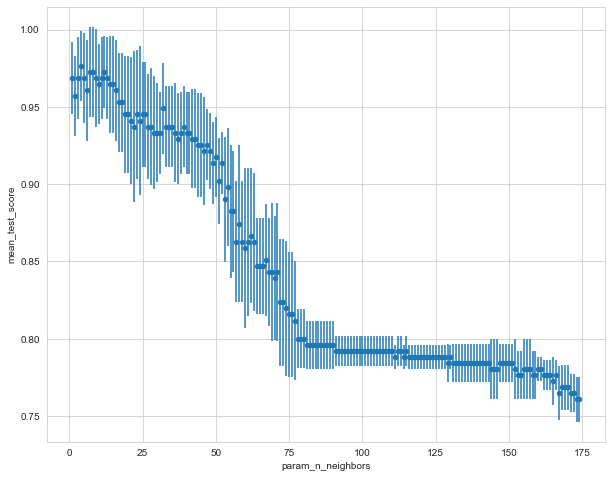

In [158]:
#Hyperparameters

#Choose the number of neighbors 

hyperparameters = {
    "n_neighbors" : range(1, 175),
}
model_2 = GridSearchCV(KNeighborsClassifier(), hyperparameters)
model_2.fit(train_X, train_y)

#Visualize 
cv_results = pd.DataFrame(model_2.cv_results_)
cv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score", figsize=(10,8))

In [168]:
#Optimize model 

#Identify the optimal value of K
optimal_k = cv_results.loc[cv_results['mean_test_score'].idxmax()]['param_n_neighbors']

#Instantiate a new K-neighbors classifier with the optimal value of K
model_3 = KNeighborsClassifier(n_neighbors=optimal_k)

#Train the new classifier on the entire training dataset
model_3.fit(train_X, train_y)

#Evaluate the model
model_3.score(test_X, test_y)


0.9764705882352941

## Visualize results 

Given that we are dealing with multiple dimentions, a confussion matrix was used to visualize the data. It compares the predicted labels of a model with the true labels from a test dataset. First, predictions are computed to fill the matrix and then they are compared with the actual labels. Model 1 (red) and Model 2 (blue) were visualized with the confussion matrix. 



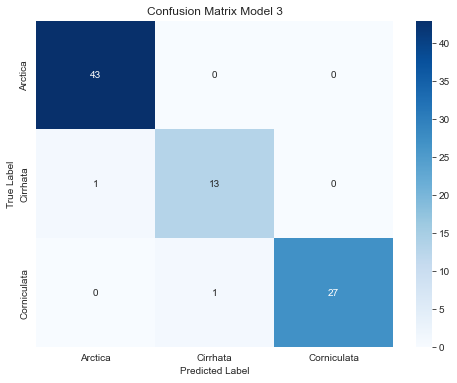

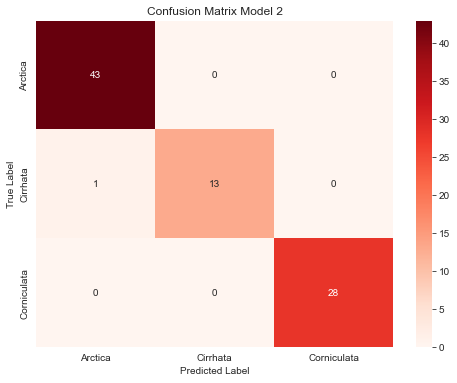

In [178]:
#Visualize model

#Model 3
#Make predictions on the test set
predictions_3 = model_3.predict(test_X)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_y, predictions_3)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=model_2.classes_, yticklabels=model_2.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Model 3')
plt.savefig('confusion_matrix_model_3.png')  # Save the plot as PNG optional
plt.show()


#Model 2
#Make predictions on the test set
predictions_1 = model_1.predict(test_X)

#Calculate confusion matrix
conf_matrix = confusion_matrix(test_y, predictions_1)


#Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Reds", fmt="d", xticklabels=model_2.classes_, yticklabels=model_2.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Model 2')
plt.savefig('confusion_matrix_model_2.png')  # Save the plot as PNG optional
plt.show()




## Analyze the results

Additionally to the accuracy score, precision, recall, and F1-score were calculated as measurements for evaluating the model performance and choosing the best one. Precision represents the proportion of true positive predictions among all positive predictions, while recall represents the proportion of true positive predictions among all actual positive instances in the dataset. The F1-score is the mean of precision and recall, providing a balanced measure of a model's performance.
A comparison table was generated to display the performance metrics for Model 1 and Model 3. Model 1 exhibited higher precision, recall, and F1-score compared to Model 3. Additionally, the confusion matrix revealed that Model 1 achieved accurate predictions for the 'Corniculata' and 'Cirrhata' species. Model 3 achieved succesful classification of 'Corniculata' only. Both models had one misclassification observed for 'Arctic'.
Further exploration of the model is recommended to enhance its robustness, as the current analysis was based on supervised learning techniques and the distribution of the response variable was not evaluated. 

In [181]:
# Make predictions on the test set for each model
predictions_1 = model_1.predict(test_X)
predictions_3 = model_3.predict(test_X)

# Calculate precision, recall, and F1-score for each model
metrics_1 = precision_recall_fscore_support(test_y, predictions_1, average='weighted')[:3]
metrics_3 = precision_recall_fscore_support(test_y, predictions_3, average='weighted')[:3]

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Model': ['Model 1', 'Model 3'],
    'Precision': [metrics_1[0], metrics_3[0]],
    'Recall': [metrics_1[1], metrics_3[1]],
    'F1-score': [metrics_1[2], metrics_3[2]]
})

# Display the results
print(results_df)

# Save the DataFrame as a CSV file optional
results_df.to_csv('model_comparison_results.csv', index=False)

     Model  Precision    Recall  F1-score
0  Model 1   0.988503  0.988235  0.988085
1  Model 3   0.976738  0.976471  0.976431
